# Simple Dataset
- Family-Friendly: 'G', 'PG', 'PG-13'
- Adult: 'R', 'NC-17', 'NR'

## Prepare Data

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load dataset
file_path = '/content/output_simp_500.csv'
df = pd.read_csv(file_path)

# Ensure all feature columns are numeric
feature_columns = [
    'overall_Violence', 'overall_Sexual Content', 'overall_General',
    'overall_Drug/Alcohol', 'overall_Profanity'
]

# Convert feature columns to numeric (if needed)
df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows where all feature columns are zero
df = df[(df[feature_columns] != 0).all(axis=1)]

# Drop irrelevant columns
irrelevant_columns = ['movie_name', 'mpaa']  # Exclude movie_name and mpaa
df = df.drop(columns=irrelevant_columns)

# Use `mpaa_category` as the target variable
X = df[feature_columns]  # Features
y = df['mpaa_category']  # Target (categories like 'Family-Friendly', 'Adult')

# Prepare Train Test Split
np.random.seed(42)

# Data with Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Display the shapes of the cleaned dataset
print("Preprocessed Dataset:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Display the distribution of the target variable
print("\nTarget Variable Distribution (Train):")
print(y_train.value_counts())

print("\nTarget Variable Distribution (Test):")
print(y_test.value_counts())


Preprocessed Dataset:
Features (X): (490, 5)
Target (y): (490,)

Target Variable Distribution (Train):
mpaa_category
Adult              201
Family-Friendly    142
Name: count, dtype: int64

Target Variable Distribution (Test):
mpaa_category
Adult              86
Family-Friendly    61
Name: count, dtype: int64


## Decision Tree

### Baseline Model


Baseline Decision Tree Results with Class Weight Balancing (Test Set):
Accuracy: 0.673, Precision: 0.672, Recall: 0.673



<Figure size 800x600 with 0 Axes>

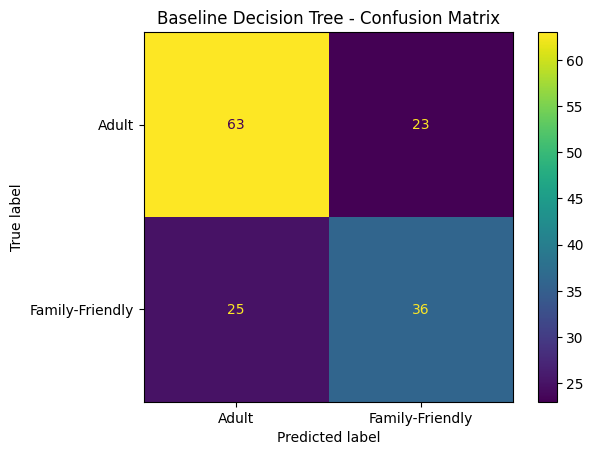

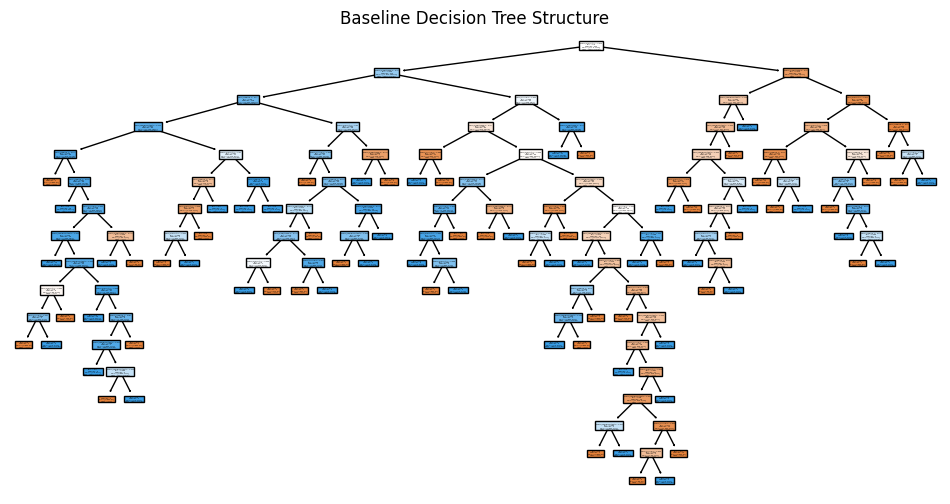

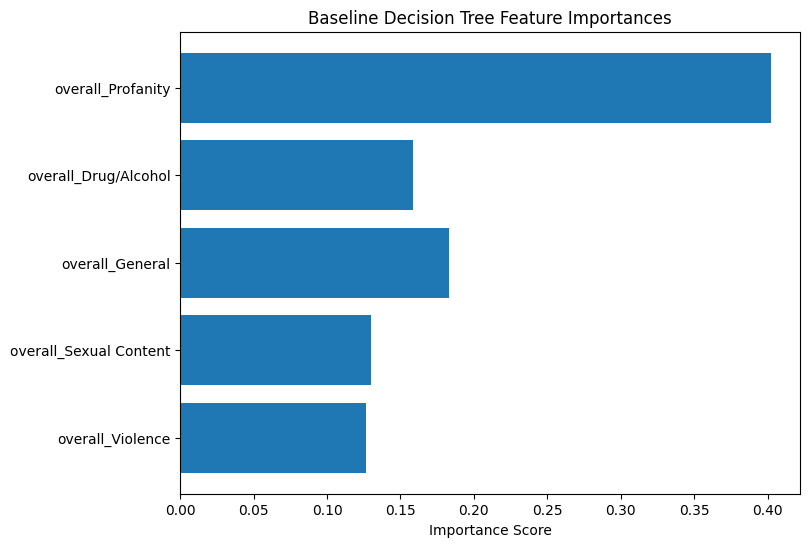




Comparison Table:
           Baseline Decision Tree
Accuracy                    0.673
Precision                   0.672
Recall                      0.673


In [38]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Initialize comparison DataFrame (if it doesn't already exist)
# Add Baseline XGBoost results to Comparison DataFrame
if 'comparison' not in globals():
  comparison = pd.DataFrame(index=["Accuracy", "Precision", "Recall"])

# Train-Test Split is already done (X_train, X_test, y_train, y_test)
# Baseline Decision Tree Model with Class Weight Balancing
baseline_tree_model = DecisionTreeClassifier(class_weight='balanced')
baseline_tree_model.fit(X_train, y_train)  # Train the model on the training set

# Predictions on the test set
baseline_tree_pred = baseline_tree_model.predict(X_test)
baseline_tree_prob = baseline_tree_model.predict_proba(X_test)

# Evaluate Baseline Decision Tree
baseline_tree_acc = accuracy_score(y_test, baseline_tree_pred)
baseline_tree_precision = precision_score(y_test, baseline_tree_pred, average='weighted')
baseline_tree_recall = recall_score(y_test, baseline_tree_pred, average='weighted')

print("\nBaseline Decision Tree Results with Class Weight Balancing (Test Set):")
print(f"Accuracy: {baseline_tree_acc:.3f}, Precision: {baseline_tree_precision:.3f}, Recall: {baseline_tree_recall:.3f}\n")

# Add Baseline Decision Tree results to Comparison DataFrame
comparison["Baseline Decision Tree"] = [baseline_tree_acc, baseline_tree_precision, baseline_tree_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, baseline_tree_pred,  # Use the test set predictions
    display_labels=y_test.unique()  # Display unique categories from the target column
)
plt.title("Baseline Decision Tree - Confusion Matrix")
plt.show()

print("\n")

# 2. Decision Tree Visualization
plt.figure(figsize=(12, 6))
plot_tree(
    baseline_tree_model, filled=True, feature_names=X.columns,
    class_names=y_train.unique()  # Display unique categories from the training set
)
plt.title("Baseline Decision Tree Structure")
plt.show()

print("\n")

# 3. Feature Importance Plot
plt.figure(figsize=(8, 6))
plt.barh(X.columns, baseline_tree_model.feature_importances_)
plt.title("Baseline Decision Tree Feature Importances")
plt.xlabel("Importance Score")
plt.show()

print("\n")

# Display comparison table
print("\nComparison Table:")
print(comparison.round(3))


### Tuned Model


Tuned Decision Tree Results (Test Set):
Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
Accuracy: 0.667, Precision: 0.662, Recall: 0.667



<Figure size 800x600 with 0 Axes>

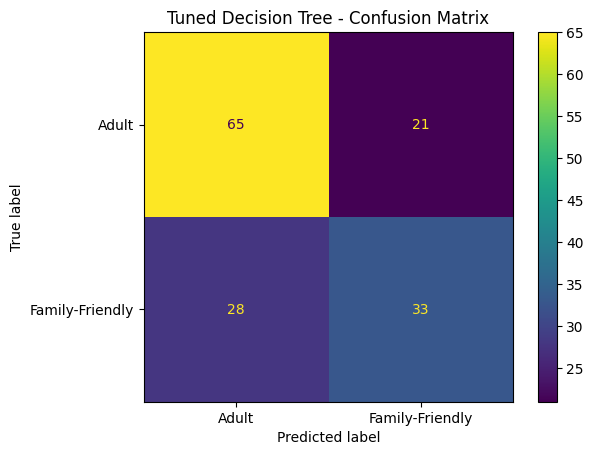

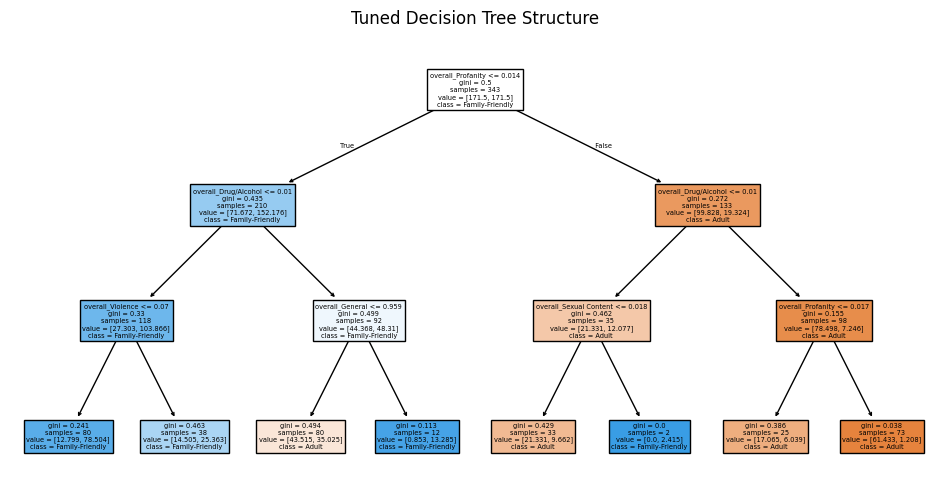

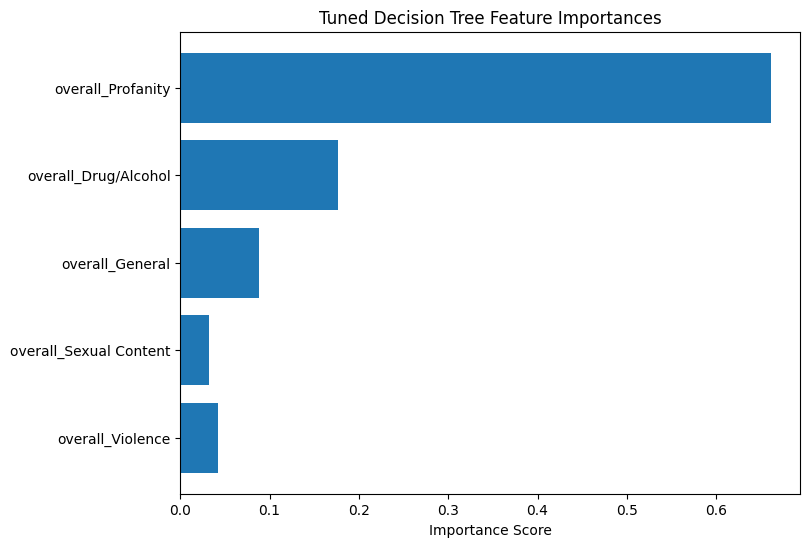




Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree
Accuracy                    0.673                0.667
Precision                   0.672                0.662
Recall                      0.673                0.667


In [39]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Hyperparameter Tuning for Decision Tree
tree_params = {
    'max_depth': range(1, 11),  # Test different tree depths
    'min_samples_split': [2, 5, 10]  # Test different minimum samples for splits
}
tree_grid = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), tree_params, cv=5, scoring='accuracy')
tree_grid.fit(X_train, y_train)

# Best Decision Tree Model
best_tree_model = tree_grid.best_estimator_

# Predictions on the test set
y_tree_pred = best_tree_model.predict(X_test)

# Evaluate Tuned Decision Tree Model
tree_acc = accuracy_score(y_test, y_tree_pred)
tree_precision = precision_score(y_test, y_tree_pred, average='weighted')
tree_recall = recall_score(y_test, y_tree_pred, average='weighted')

print("\nTuned Decision Tree Results (Test Set):")
print(f"Best Parameters: {tree_grid.best_params_}")
print(f"Accuracy: {tree_acc:.3f}, Precision: {tree_precision:.3f}, Recall: {tree_recall:.3f}\n")

# Add Tuned Decision Tree results to Comparison DataFrame
comparison["Tuned Decision Tree"] = [tree_acc, tree_precision, tree_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_tree_pred,
    display_labels=y_test.unique()  # Display unique categories from the test set
)
plt.title("Tuned Decision Tree - Confusion Matrix")
plt.show()

print("\n")

# 2. Decision Tree Visualization
plt.figure(figsize=(12, 6))
plot_tree(
    best_tree_model, filled=True, feature_names=X.columns,
    class_names=y_train.unique()  # Use unique categories from the training set
)
plt.title("Tuned Decision Tree Structure")
plt.show()

print("\n")

# 3. Feature Importance
plt.figure(figsize=(8, 6))
plt.barh(X.columns, best_tree_model.feature_importances_)
plt.title("Tuned Decision Tree Feature Importances")
plt.xlabel("Importance Score")
plt.show()

print("\n")

# Display comparison table
print("\nComparison Table:")
print(comparison.round(3))


## Random Forest

### Baseline Model


Baseline Random Forest Results (Test Set):
Accuracy: 0.694, Precision: 0.690, Recall: 0.694



<Figure size 800x600 with 0 Axes>

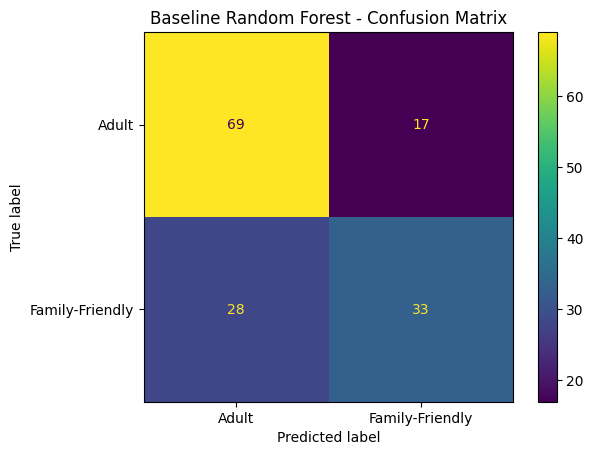

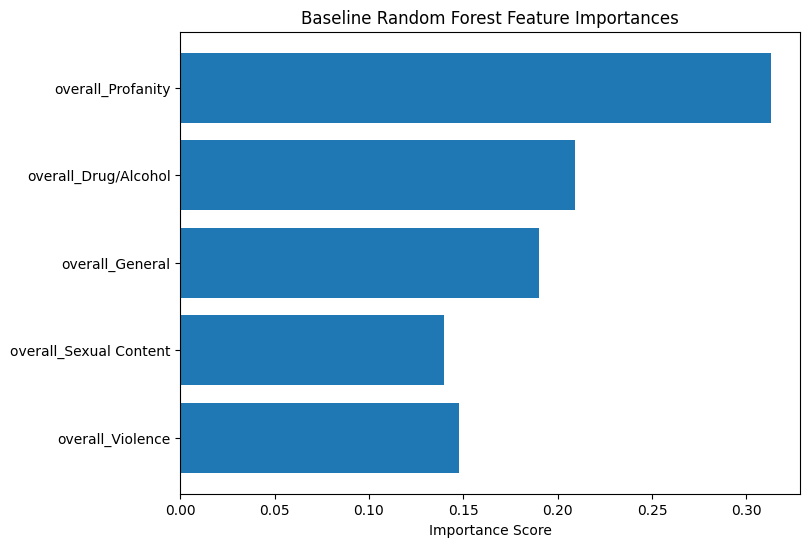


Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  Baseline Random Forest
Accuracy                    0.673                0.667                   0.694
Precision                   0.672                0.662                   0.690
Recall                      0.673                0.667                   0.694


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Baseline Random Forest Classifier
baseline_rf_model = RandomForestClassifier(random_state=42)  # Add random_state for reproducibility
baseline_rf_model.fit(X_train, y_train)  # Fit the model using the training set

# Predictions on the test set
baseline_rf_pred = baseline_rf_model.predict(X_test)

# Evaluate Baseline Random Forest
baseline_rf_acc = accuracy_score(y_test, baseline_rf_pred)
baseline_rf_precision = precision_score(y_test, baseline_rf_pred, average='weighted')
baseline_rf_recall = recall_score(y_test, baseline_rf_pred, average='weighted')

print("\nBaseline Random Forest Results (Test Set):")
print(f"Accuracy: {baseline_rf_acc:.3f}, Precision: {baseline_rf_precision:.3f}, Recall: {baseline_rf_recall:.3f}\n")

# Add Baseline Random Forest results to Comparison DataFrame
comparison["Baseline Random Forest"] = [baseline_rf_acc, baseline_rf_precision, baseline_rf_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, baseline_rf_pred,
    display_labels=y_test.unique()  # Use unique categories from the test set
)
plt.title("Baseline Random Forest - Confusion Matrix")
plt.show()

print("\n")

# 2. Feature Importance
plt.figure(figsize=(8, 6))
plt.barh(X.columns, baseline_rf_model.feature_importances_)
plt.title("Baseline Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.show()

# Display comparison table
print("\nComparison Table:")
print(comparison.round(3))


### Tuned Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters from RandomizedSearchCV: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None}

Tuned Random Forest Results (Test Set):
Accuracy: 0.687, Precision: 0.686, Recall: 0.687



<Figure size 800x600 with 0 Axes>

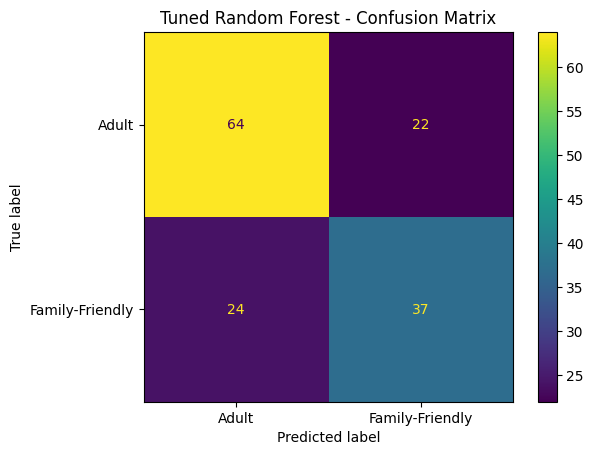

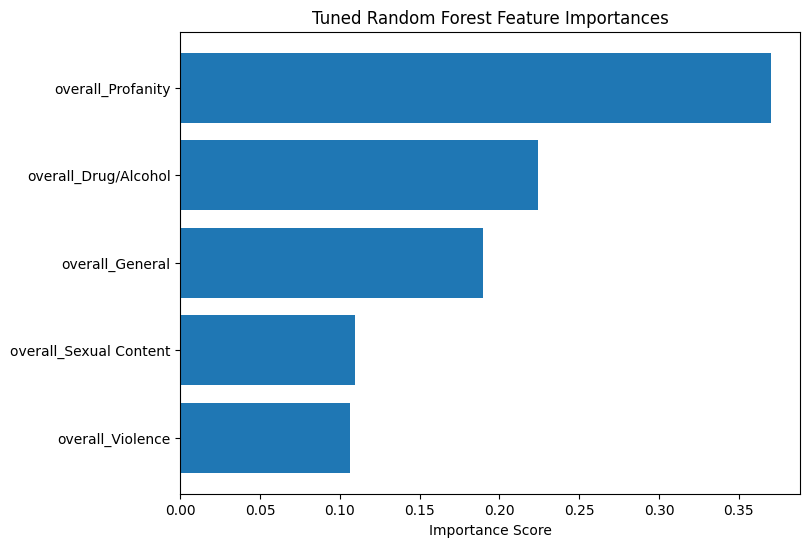




Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  \
Accuracy                    0.673                0.667   
Precision                   0.672                0.662   
Recall                      0.673                0.667   

           Baseline Random Forest  Tuned Random Forest  \
Accuracy                    0.694                0.687   
Precision                   0.690                0.686   
Recall                      0.694                0.687   

           Baseline Gradient Boosting  Tuned Gradient Boosting  DNN Model  \
Accuracy                        0.680                    0.694      0.707   
Precision                       0.677                    0.693      0.708   
Recall                          0.680                    0.694      0.707   

           Tuned DNN Model  Baseline CatBoost  Tuned CatBoost  \
Accuracy             0.735              0.687           0.694   
Precision            0.747              0.689           0.698   
Recall   

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Parameter Grid for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],      # Number of trees in the forest
    'max_depth': [10, 15, 20, None],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 5],       # Minimum samples at leaf nodes
    'max_features': ['sqrt', 'log2']     # Number of features to consider at each split
}

# RandomizedSearchCV: Faster Tuning
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=rf_params,
    n_iter=50,            # Number of parameter combinations to try
    scoring='accuracy',   # Scoring metric
    cv=5,                 # 5-fold cross-validation
    verbose=1,            # Show progress during tuning
    random_state=42,
    n_jobs=-1             # Use all available cores
)

# Train RandomizedSearchCV on the training data
rf_random.fit(X_train, y_train)

# Best parameters and best model
best_rf_model = rf_random.best_estimator_
print("\nBest Parameters from RandomizedSearchCV:", rf_random.best_params_)

# Predictions on the test set
y_rf_pred = best_rf_model.predict(X_test)

# Evaluate Tuned Random Forest Model
rf_acc = accuracy_score(y_test, y_rf_pred)
rf_precision = precision_score(y_test, y_rf_pred, average='weighted')
rf_recall = recall_score(y_test, y_rf_pred, average='weighted')

print("\nTuned Random Forest Results (Test Set):")
print(f"Accuracy: {rf_acc:.3f}, Precision: {rf_precision:.3f}, Recall: {rf_recall:.3f}\n")

comparison["Tuned Random Forest"] = [rf_acc, rf_precision, rf_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_rf_pred,
    display_labels=y_test.unique()  # Display unique categories from the test set
)
plt.title("Tuned Random Forest - Confusion Matrix")
plt.show()

print('\n')

# 2. Feature Importance
plt.figure(figsize=(8, 6))
plt.barh(X.columns, best_rf_model.feature_importances_)
plt.title("Tuned Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.show()

print('\n')

# Display Comparison Table
print("\nComparison Table:")
print(comparison.round(3))


## Gradient Boosting

### Baseline Model


Baseline Gradient Boosting Results (Test Set):
Accuracy: 0.680, Precision: 0.677, Recall: 0.680



<Figure size 800x600 with 0 Axes>

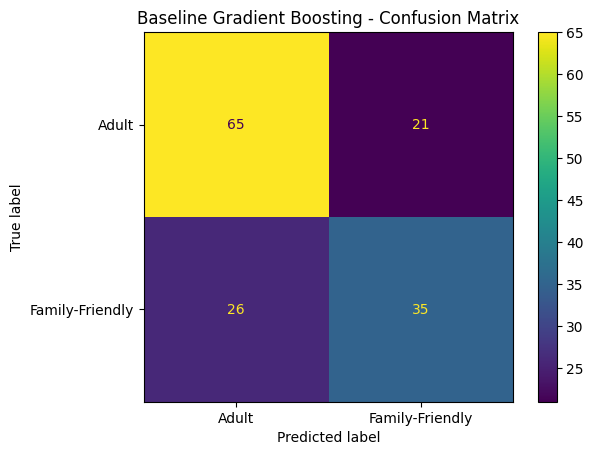

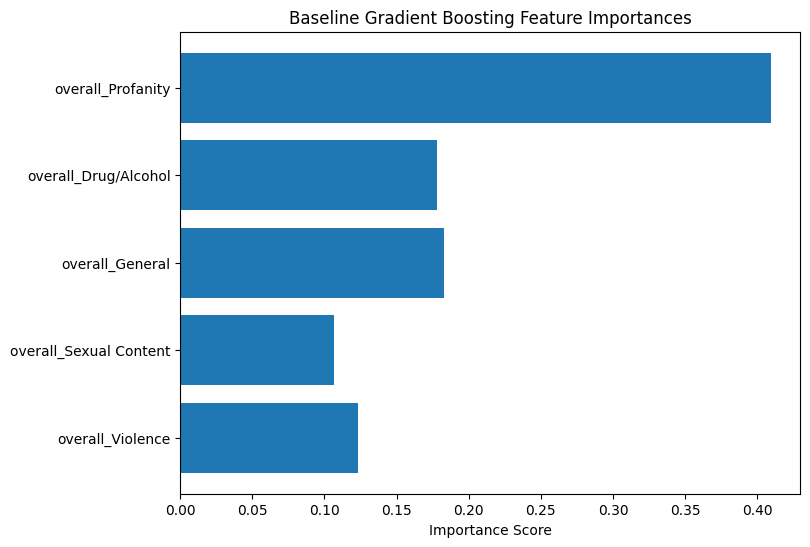




Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  \
Accuracy                    0.673                0.667   
Precision                   0.672                0.662   
Recall                      0.673                0.667   

           Baseline Random Forest  Tuned Random Forest  \
Accuracy                    0.694                0.667   
Precision                   0.690                0.661   
Recall                      0.694                0.667   

           Baseline Gradient Boosting  
Accuracy                        0.680  
Precision                       0.677  
Recall                          0.680  


In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Baseline Gradient Boosting Model
baseline_gb_model = GradientBoostingClassifier(random_state=42)
baseline_gb_model.fit(X_train, y_train)  # Fit the model using the training set

# Predictions on the test set
y_gb_pred = baseline_gb_model.predict(X_test)

# Evaluate Baseline Gradient Boosting Model
gb_acc = accuracy_score(y_test, y_gb_pred)
gb_precision = precision_score(y_test, y_gb_pred, average='weighted')
gb_recall = recall_score(y_test, y_gb_pred, average='weighted')

print("\nBaseline Gradient Boosting Results (Test Set):")
print(f"Accuracy: {gb_acc:.3f}, Precision: {gb_precision:.3f}, Recall: {gb_recall:.3f}\n")

# Add Baseline Gradient Boosting results to Comparison DataFrame
comparison["Baseline Gradient Boosting"] = [gb_acc, gb_precision, gb_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_gb_pred,
    display_labels=y_test.unique()  # Display unique categories from the test set
)
plt.title("Baseline Gradient Boosting - Confusion Matrix")
plt.show()

print("\n")

# 2. Feature Importance
plt.figure(figsize=(8, 6))
plt.barh(X.columns, baseline_gb_model.feature_importances_)
plt.title("Baseline Gradient Boosting Feature Importances")
plt.xlabel("Importance Score")
plt.show()

print("\n")

# Display comparison table
print("\nComparison Table:")
print(comparison.round(3))


### Tuned Model


Tuned Gradient Boosting Results (Test Set):
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 150}
Accuracy: 0.694, Precision: 0.693, Recall: 0.694



<Figure size 800x600 with 0 Axes>

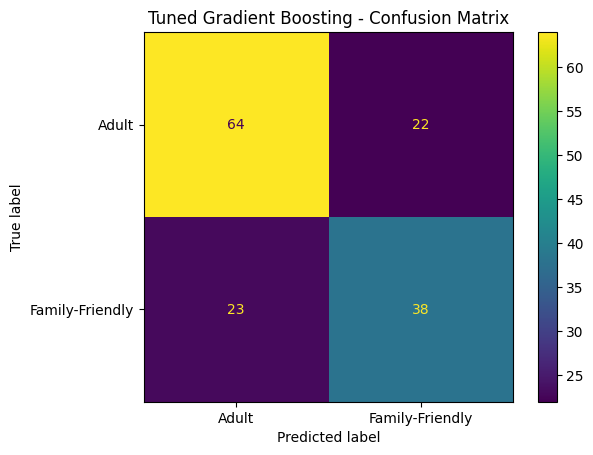

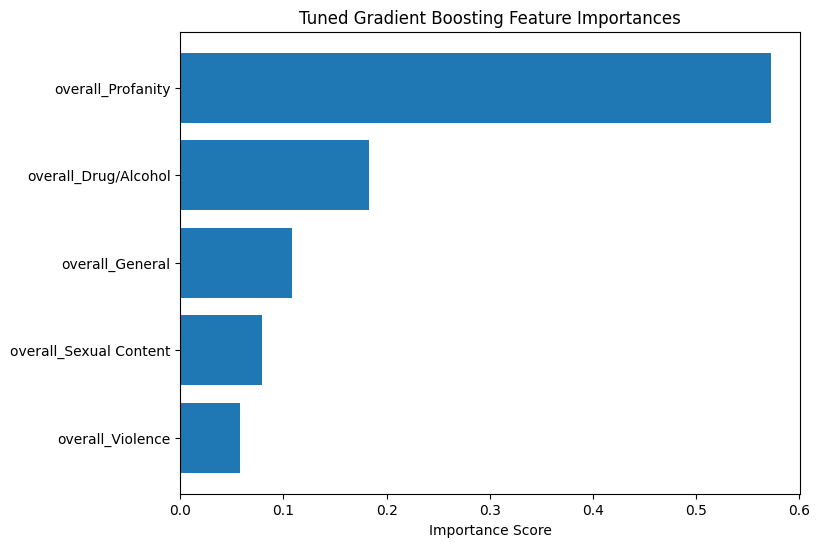




Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  \
Accuracy                    0.673                0.667   
Precision                   0.672                0.662   
Recall                      0.673                0.667   

           Baseline Random Forest  Tuned Random Forest  \
Accuracy                    0.694                0.667   
Precision                   0.690                0.661   
Recall                      0.694                0.667   

           Baseline Gradient Boosting  Tuned Gradient Boosting  
Accuracy                        0.680                    0.694  
Precision                       0.677                    0.693  
Recall                          0.680                    0.694  


In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Hyperparameter Tuning for Gradient Boosting
gb_params = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks contribution of each tree
    'max_depth': [3, 5, 7],  # Maximum depth of the individual regression estimators
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split a node
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X_train, y_train)

# Best Gradient Boosting Model
best_gb_model = gb_grid.best_estimator_

# Predictions on the test set
y_gb_pred = best_gb_model.predict(X_test)

# Evaluate Tuned Gradient Boosting Model
tuned_gb_acc = accuracy_score(y_test, y_gb_pred)
tuned_gb_precision = precision_score(y_test, y_gb_pred, average='weighted')
tuned_gb_recall = recall_score(y_test, y_gb_pred, average='weighted')

print("\nTuned Gradient Boosting Results (Test Set):")
print(f"Best Parameters: {gb_grid.best_params_}")
print(f"Accuracy: {tuned_gb_acc:.3f}, Precision: {tuned_gb_precision:.3f}, Recall: {tuned_gb_recall:.3f}\n")

# Add Tuned Gradient Boosting results to Comparison DataFrame
comparison["Tuned Gradient Boosting"] = [tuned_gb_acc, tuned_gb_precision, tuned_gb_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_gb_pred,
    display_labels=y_test.unique()  # Display unique categories from the test set
)
plt.title("Tuned Gradient Boosting - Confusion Matrix")
plt.show()

print("\n")

# 2. Feature Importance
plt.figure(figsize=(8, 6))
plt.barh(X.columns, best_gb_model.feature_importances_)
plt.title("Tuned Gradient Boosting Feature Importances")
plt.xlabel("Importance Score")
plt.show()

print("\n")

# Display comparison table
print("\nComparison Table:")
print(comparison.round(3))


## DNN

### Baseline Model

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.5006 - loss: 0.7324 - val_accuracy: 0.7347 - val_loss: 0.5925
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6284 - loss: 0.6331 - val_accuracy: 0.7075 - val_loss: 0.5495
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7244 - loss: 0.5802 - val_accuracy: 0.7211 - val_loss: 0.5307
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7232 - loss: 0.5758 - val_accuracy: 0.7143 - val_loss: 0.5270
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7034 - loss: 0.5770 - val_accuracy: 0.7075 - val_loss: 0.5274
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7409 - loss: 0.5658 - val_accuracy: 0.7075 - val_loss: 0.5240
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7366 - loss: 0.5510 - val_accuracy: 0.7143 - val_loss: 0.5223
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7351 - loss: 0.5101 - val_accuracy: 0.7075 - val_loss: 0.52

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Classification Report:
                 precision    recall  f1-score   support

          Adult       0.75      0.74      0.75        86
Family-Friendly       0.65      0.66      0.65        61

       accuracy                           0.71       147
      macro avg       0.70      0.70      0.70       147
   weighted avg       0.71      0.71      0.71       147



<Figure size 800x600 with 0 Axes>

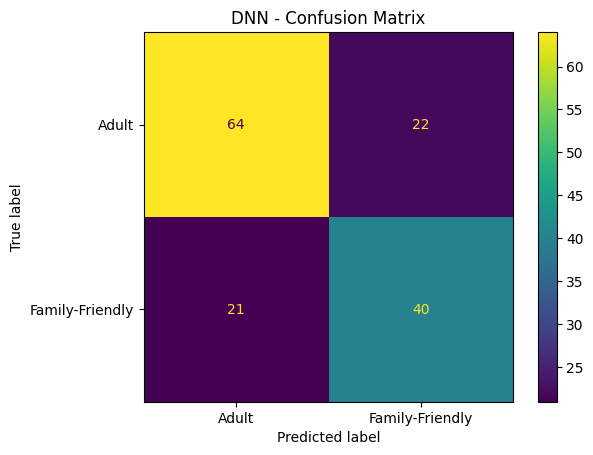

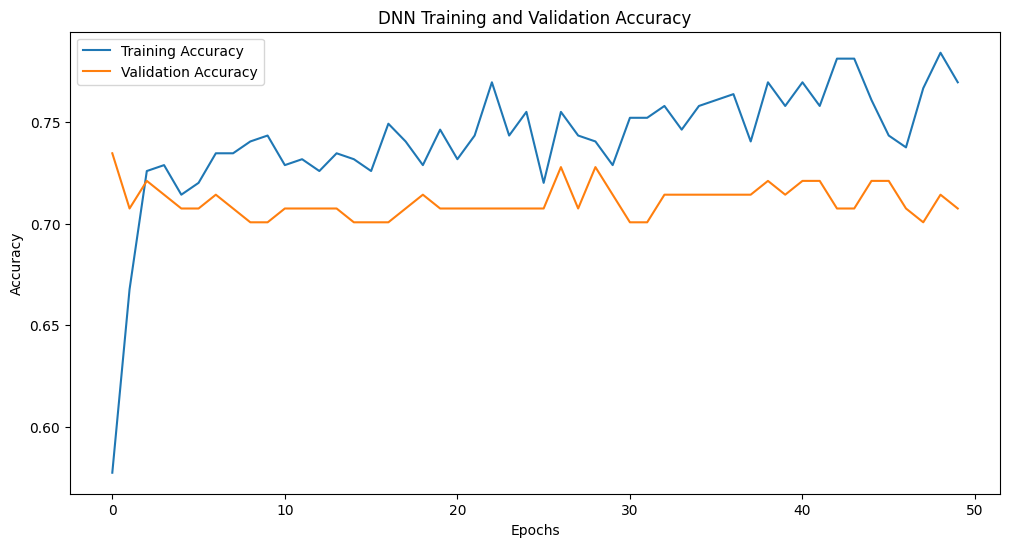




Updated Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  \
Accuracy                    0.673                0.667   
Precision                   0.672                0.662   
Recall                      0.673                0.667   

           Baseline Random Forest  Tuned Random Forest  \
Accuracy                    0.694                0.667   
Precision                   0.690                0.661   
Recall                      0.694                0.667   

           Baseline Gradient Boosting  Tuned Gradient Boosting  DNN Model  
Accuracy                        0.680                    0.694      0.707  
Precision                       0.677                    0.693      0.708  
Recall                          0.680                    0.694      0.707  


In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the Comparison DataFrame if it doesn't exist
if 'comparison' not in globals():
    comparison = pd.DataFrame(index=["Accuracy", "Precision", "Recall"])

# Assuming X and y are already prepared
# Convert categorical target (mpaa_category) to numeric labels
label_encoder = LabelEncoder()
y_dnn_encoded = label_encoder.fit_transform(y)  # Encode mpaa_category as integers
y_dnn_categorical = to_categorical(y_dnn_encoded)  # One-hot encode the target variable

# Train-Test Split (Renamed variables)
X_dnn_train, X_dnn_test, y_dnn_train, y_dnn_test = train_test_split(
    X, y_dnn_categorical, test_size=0.3, random_state=42, stratify=y_dnn_categorical
)

# Feature Scaling
scaler = StandardScaler()
X_dnn_train_scaled = scaler.fit_transform(X_dnn_train)
X_dnn_test_scaled = scaler.transform(X_dnn_test)

# Build the DNN Model
dnn_model = Sequential([
    Dense(128, input_dim=X_dnn_train_scaled.shape[1], activation='relu'),  # Input layer
    Dropout(0.3),  # Dropout to prevent overfitting
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.3),
    Dense(y_dnn_train.shape[1], activation='softmax')  # Output layer with softmax for multiclass classification
])

# Compile the Model
dnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model
dnn_history = dnn_model.fit(
    X_dnn_train_scaled, y_dnn_train,
    validation_data=(X_dnn_test_scaled, y_dnn_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the Model
test_loss, test_accuracy = dnn_model.evaluate(X_dnn_test_scaled, y_dnn_test, verbose=0)
print(f"\nDNN Test Accuracy: {test_accuracy:.3f}")

# Predictions
y_dnn_pred = dnn_model.predict(X_dnn_test_scaled)
y_dnn_pred_classes = np.argmax(y_dnn_pred, axis=1)  # Convert one-hot predictions to class labels
y_dnn_test_classes = np.argmax(y_dnn_test, axis=1)  # Convert one-hot test labels to class labels

# Decode class labels back to original categories
y_dnn_pred_labels = label_encoder.inverse_transform(y_dnn_pred_classes)
y_dnn_test_labels = label_encoder.inverse_transform(y_dnn_test_classes)

# Compute Precision and Recall
dnn_precision = precision_score(y_dnn_test_classes, y_dnn_pred_classes, average='weighted')
dnn_recall = recall_score(y_dnn_test_classes, y_dnn_pred_classes, average='weighted')

# Add DNN results to the Comparison DataFrame
comparison["Baseline DNN Model"] = [test_accuracy, dnn_precision, dnn_recall]

# Metrics and Classification Report
print("\nClassification Report:")
print(classification_report(y_dnn_test_labels, y_dnn_pred_labels))

# Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_dnn_test_labels, y_dnn_pred_labels,
    display_labels=label_encoder.classes_
)
plt.title("DNN - Confusion Matrix")
plt.show()

print("\n")

# Plot Training History
plt.figure(figsize=(12, 6))
plt.plot(dnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(dnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title("DNN Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("\n")

# Print Comparison Table
print("\nUpdated Comparison Table:")
print(comparison.round(3))


### Tuned DNN

Trial 10 Complete [00h 00m 07s]
val_accuracy: 0.7346938848495483

Best val_accuracy So Far: 0.7414966225624084
Total elapsed time: 00h 01m 20s
Best Hyperparameters: {'units_input': 224, 'dropout_input': 0.30000000000000004, 'num_layers': 3, 'units_hidden_0': 192, 'dropout_hidden_0': 0.1, 'learning_rate': 0.0026187837487828816, 'units_hidden_1': 96, 'dropout_hidden_1': 0.30000000000000004, 'units_hidden_2': 64, 'dropout_hidden_2': 0.30000000000000004}
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6059 - loss: 0.6549 - val_accuracy: 0.7211 - val_loss: 0.5273
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7104 - loss: 0.5460 - val_accuracy: 0.7211 - val_loss: 0.5190
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7413 - loss: 0.5382 - val_accuracy: 0.7211 - val_loss: 0.5328
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7030 - loss: 0.5582 - val_accuracy: 0.7143 - val_loss: 0.5125
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0

<Figure size 800x600 with 0 Axes>

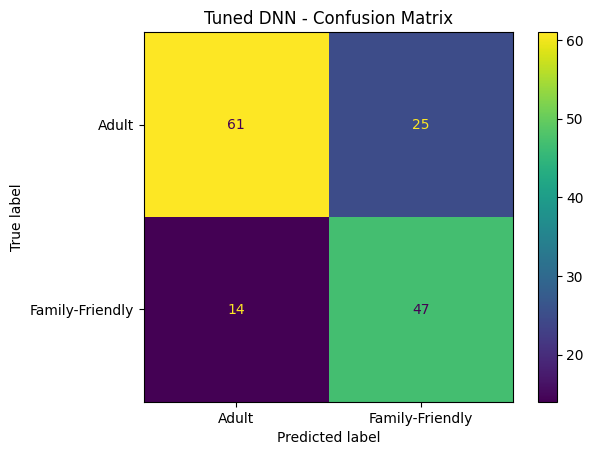

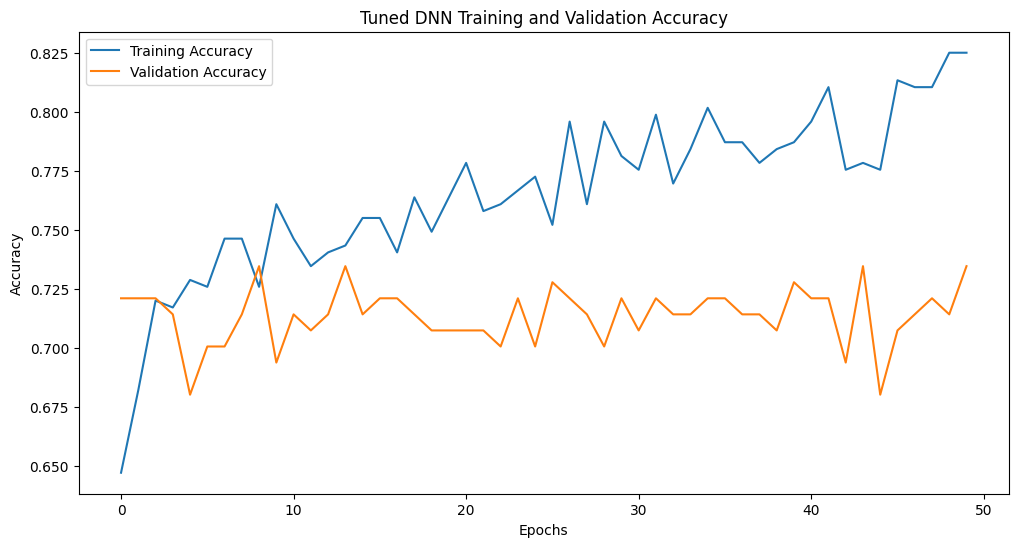




Updated Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  \
Accuracy                    0.673                0.667   
Precision                   0.672                0.662   
Recall                      0.673                0.667   

           Baseline Random Forest  Tuned Random Forest  \
Accuracy                    0.694                0.667   
Precision                   0.690                0.661   
Recall                      0.694                0.667   

           Baseline Gradient Boosting  Tuned Gradient Boosting  DNN Model  \
Accuracy                        0.680                    0.694      0.707   
Precision                       0.677                    0.693      0.708   
Recall                          0.680                    0.694      0.707   

           Tuned DNN Model  
Accuracy             0.735  
Precision            0.747  
Recall               0.735  


In [52]:
!pip install keras-tuner
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, classification_report, ConfusionMatrixDisplay

# Define the model builder function for KerasTuner
def build_model(hp):
    model = Sequential()
    # Input Layer
    model.add(Dense(
        units=hp.Int('units_input', min_value=64, max_value=256, step=32),
        activation='relu', input_dim=X_dnn_train_scaled.shape[1]
    ))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))

    # Hidden Layer(s)
    for i in range(hp.Int('num_layers', 1, 3)):  # Tune the number of hidden layers
        model.add(Dense(
            units=hp.Int(f'units_hidden_{i}', min_value=64, max_value=256, step=32),
            activation='relu'
        ))
        model.add(Dropout(hp.Float(f'dropout_hidden_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(y_dnn_train.shape[1], activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize KerasTuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different models to test
    executions_per_trial=1,  # Number of repetitions per model configuration
    directory='tuning',
    project_name='dnn_tuning'
)

# Search for the best hyperparameters
tuner.search(X_dnn_train_scaled, y_dnn_train, validation_data=(X_dnn_test_scaled, y_dnn_test),
             epochs=30, batch_size=32, verbose=1)

# Get the best model
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:", best_hyperparameters.values)

# Build and Train the Best Model
best_model = tuner.hypermodel.build(best_hyperparameters)
history = best_model.fit(
    X_dnn_train_scaled, y_dnn_train,
    validation_data=(X_dnn_test_scaled, y_dnn_test),
    epochs=50, batch_size=32, verbose=1
)

# Evaluate the Best Model
test_loss, test_accuracy = best_model.evaluate(X_dnn_test_scaled, y_dnn_test, verbose=0)
print(f"\nBest DNN Test Accuracy: {test_accuracy:.3f}")

# Predictions
y_best_pred = best_model.predict(X_dnn_test_scaled)
y_best_pred_classes = np.argmax(y_best_pred, axis=1)
y_test_classes = np.argmax(y_dnn_test, axis=1)

# Decode predictions back to labels
y_best_pred_labels = label_encoder.inverse_transform(y_best_pred_classes)
y_test_labels = label_encoder.inverse_transform(y_test_classes)

# Metrics and Classification Report
precision = precision_score(y_test_classes, y_best_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_best_pred_classes, average='weighted')

print("\nClassification Report:")
print(classification_report(y_test_labels, y_best_pred_labels))

# Add to Comparison DataFrame
comparison["Tuned DNN Model"] = [test_accuracy, precision, recall]

# Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_labels, y_best_pred_labels,
    display_labels=label_encoder.classes_
)
plt.title("Tuned DNN - Confusion Matrix")
plt.show()

print("\n")

# Training History Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Tuned DNN Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("\n")

# Print Comparison Table
print("\nUpdated Comparison Table:")
print(comparison.round(3))


## CatBoost

### Baseline Model

Class Weights: [0.8532338308457711, 1.2077464788732395]

Baseline CatBoost Results (Test Set):
Accuracy: 0.687, Precision: 0.689, Recall: 0.687



<Figure size 800x600 with 0 Axes>

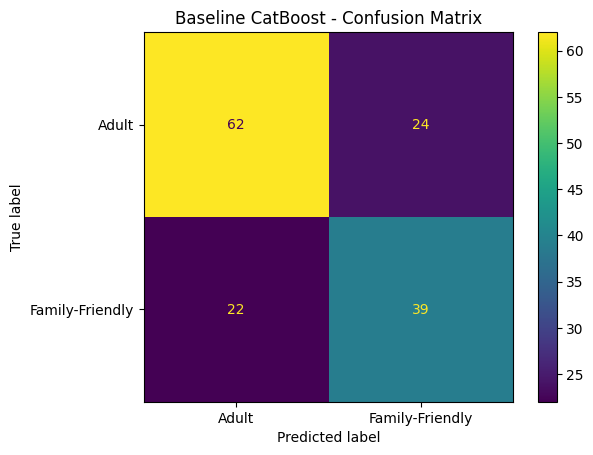

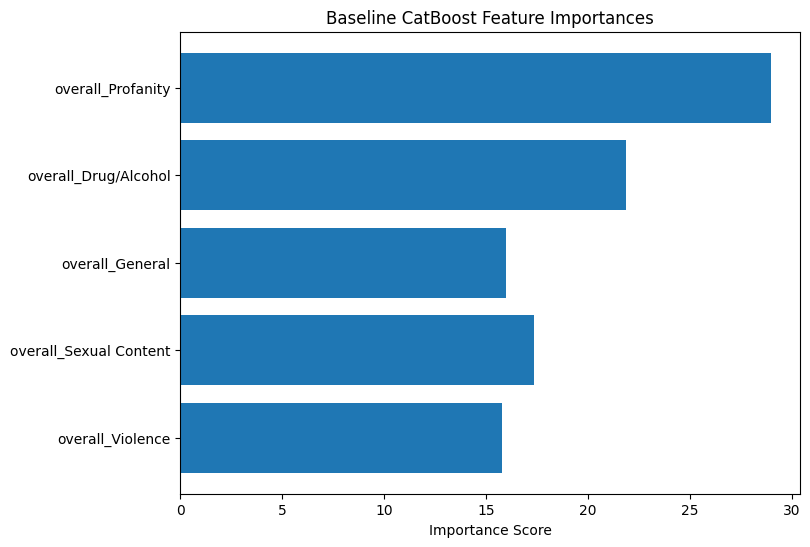




Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  \
Accuracy                    0.673                0.667   
Precision                   0.672                0.662   
Recall                      0.673                0.667   

           Baseline Random Forest  Tuned Random Forest  \
Accuracy                    0.694                0.667   
Precision                   0.690                0.661   
Recall                      0.694                0.667   

           Baseline Gradient Boosting  Tuned Gradient Boosting  DNN Model  \
Accuracy                        0.680                    0.694      0.707   
Precision                       0.677                    0.693      0.708   
Recall                          0.680                    0.694      0.707   

           Tuned DNN Model  Baseline CatBoost  
Accuracy             0.735              0.687  
Precision            0.747              0.689  
Recall               0.735              0.687  


In [57]:
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights based on the target class distribution
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a list (CatBoost requires a list)
class_weights = class_weights.tolist()
print(f"Class Weights: {class_weights}")

# Baseline CatBoost Model with Class Weights
baseline_cb_model = CatBoostClassifier(random_seed=42, verbose=0, class_weights=class_weights)
baseline_cb_model.fit(X_train, y_train)

# Predictions on the test set
y_cb_pred = baseline_cb_model.predict(X_test)

# Evaluate Baseline CatBoost Model
cb_acc = accuracy_score(y_test, y_cb_pred)
cb_precision = precision_score(y_test, y_cb_pred, average='weighted')
cb_recall = recall_score(y_test, y_cb_pred, average='weighted')

print("\nBaseline CatBoost Results (Test Set):")
print(f"Accuracy: {cb_acc:.3f}, Precision: {cb_precision:.3f}, Recall: {cb_recall:.3f}\n")

# Add Baseline CatBoost results to Comparison DataFrame
comparison["Baseline CatBoost"] = [cb_acc, cb_precision, cb_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_cb_pred,
    display_labels=y_test.unique()  # Display unique categories from the test set
)
plt.title("Baseline CatBoost - Confusion Matrix")
plt.show()

print("\n")

# 2. Feature Importance
plt.figure(figsize=(8, 6))
plt.barh(X.columns, baseline_cb_model.feature_importances_)
plt.title("Baseline CatBoost Feature Importances")
plt.xlabel("Importance Score")
plt.show()

print("\n")

# Display comparison table
print("\nComparison Table:")
print(comparison.round(3))


### Tuned Model

Class Weights: [0.8532338308457711, 1.2077464788732395]
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best Parameters: {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.01}

Tuned CatBoost Results (Test Set):
Accuracy: 0.694, Precision: 0.698, Recall: 0.694



<Figure size 800x600 with 0 Axes>

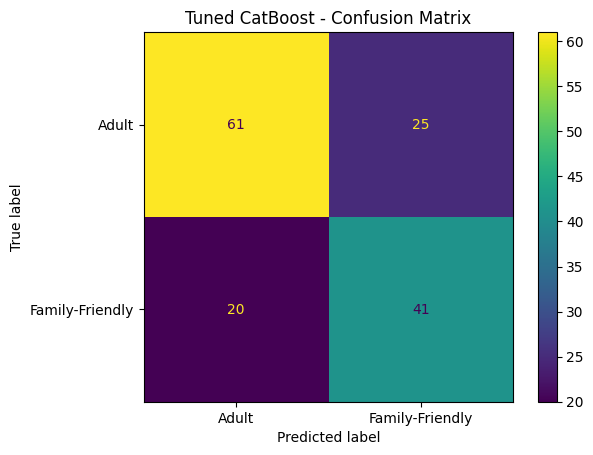

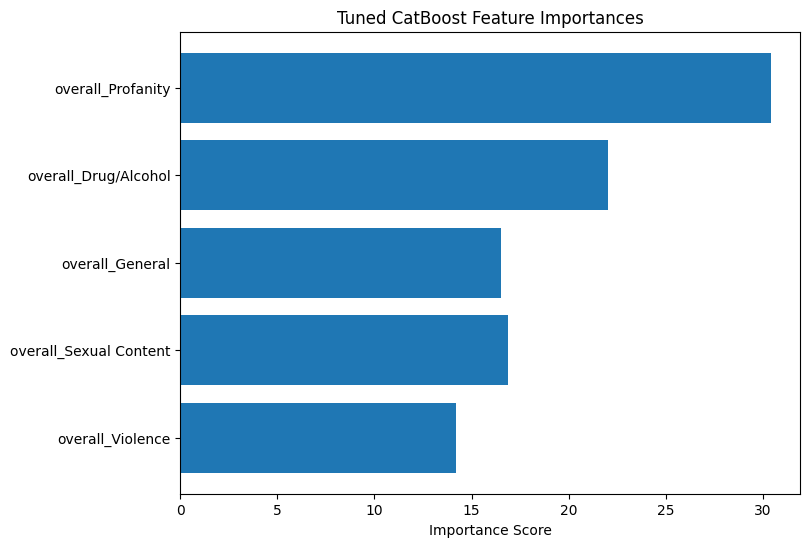




Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  \
Accuracy                    0.673                0.667   
Precision                   0.672                0.662   
Recall                      0.673                0.667   

           Baseline Random Forest  Tuned Random Forest  \
Accuracy                    0.694                0.667   
Precision                   0.690                0.661   
Recall                      0.694                0.667   

           Baseline Gradient Boosting  Tuned Gradient Boosting  DNN Model  \
Accuracy                        0.680                    0.694      0.707   
Precision                       0.677                    0.693      0.708   
Recall                          0.680                    0.694      0.707   

           Tuned DNN Model  Baseline CatBoost  Tuned CatBoost  
Accuracy             0.735              0.687           0.694  
Precision            0.747              0.689           0.698  
Recall      

In [58]:
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Compute class weights based on the target class distribution
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a list (CatBoost requires a list)
class_weights = class_weights.tolist()
print(f"Class Weights: {class_weights}")

# Define the parameter grid for tuning
param_grid = {
    'iterations': [200, 500, 1000],  # Number of boosting iterations
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'depth': [4, 6, 8],  # Depth of the tree
    'l2_leaf_reg': [1, 3, 5]  # Regularization coefficient
}

# Initialize CatBoostClassifier with fixed class weights
cb_model = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    class_weights=class_weights
)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=cb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # Cross-validation folds
    verbose=1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
print("\nBest Parameters:", best_params)

# Use the best model
best_cb_model = grid_search.best_estimator_

# Predictions on the test set
y_cb_pred = best_cb_model.predict(X_test)

# Evaluate the Tuned CatBoost Model
cb_acc = accuracy_score(y_test, y_cb_pred)
cb_precision = precision_score(y_test, y_cb_pred, average='weighted')
cb_recall = recall_score(y_test, y_cb_pred, average='weighted')

print("\nTuned CatBoost Results (Test Set):")
print(f"Accuracy: {cb_acc:.3f}, Precision: {cb_precision:.3f}, Recall: {cb_recall:.3f}\n")

# Add Tuned CatBoost results to Comparison DataFrame
comparison["Tuned CatBoost"] = [cb_acc, cb_precision, cb_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_cb_pred,
    display_labels=y_test.unique()  # Display unique categories from the test set
)
plt.title("Tuned CatBoost - Confusion Matrix")
plt.show()

print("\n")

# 2. Feature Importance
plt.figure(figsize=(8, 6))
plt.barh(X.columns, best_cb_model.feature_importances_)
plt.title("Tuned CatBoost Feature Importances")
plt.xlabel("Importance Score")
plt.show()

print("\n")

# Display comparison table
print("\nComparison Table:")
print(comparison.round(3))

## XGBoost

### Baseline Model


Baseline XGBoost Results (Test Set):
Accuracy: 0.680, Precision: 0.676, Recall: 0.680



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:15:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 800x600 with 0 Axes>

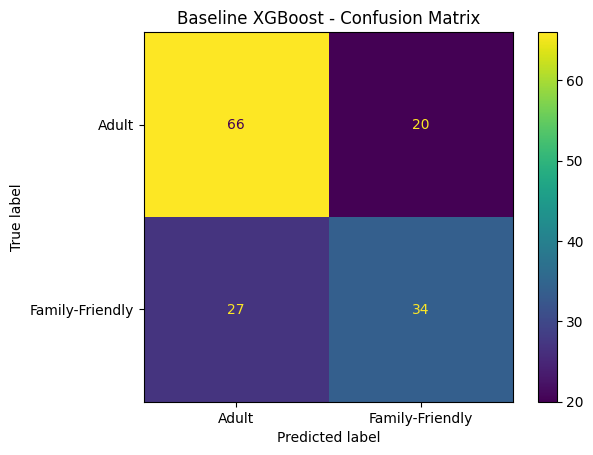

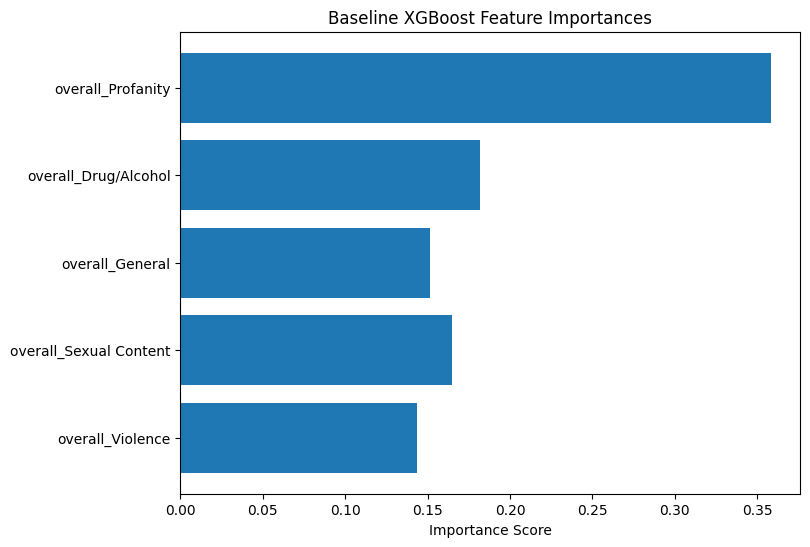




Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  \
Accuracy                    0.673                0.667   
Precision                   0.672                0.662   
Recall                      0.673                0.667   

           Baseline Random Forest  Tuned Random Forest  \
Accuracy                    0.694                0.667   
Precision                   0.690                0.661   
Recall                      0.694                0.667   

           Baseline Gradient Boosting  Tuned Gradient Boosting  DNN Model  \
Accuracy                        0.680                    0.694      0.707   
Precision                       0.677                    0.693      0.708   
Recall                          0.680                    0.694      0.707   

           Tuned DNN Model  Baseline CatBoost  Tuned CatBoost  \
Accuracy             0.735              0.687           0.694   
Precision            0.747              0.689           0.698   
Recall   

In [60]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Encode target labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encode y_train
y_test_encoded = label_encoder.transform(y_test)  # Encode y_test using the same encoder

# Baseline XGBoost Model
baseline_xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
baseline_xgb_model.fit(X_train, y_train_encoded)  # Fit the model using the training set

# Predictions on the test set
y_xgb_pred = baseline_xgb_model.predict(X_test)

# Decode predictions and actual test labels back to original string labels
y_xgb_pred_labels = label_encoder.inverse_transform(y_xgb_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Evaluate Baseline XGBoost Model
xgb_acc = accuracy_score(y_test_labels, y_xgb_pred_labels)
xgb_precision = precision_score(y_test_labels, y_xgb_pred_labels, average='weighted')
xgb_recall = recall_score(y_test_labels, y_xgb_pred_labels, average='weighted')

print("\nBaseline XGBoost Results (Test Set):")
print(f"Accuracy: {xgb_acc:.3f}, Precision: {xgb_precision:.3f}, Recall: {xgb_recall:.3f}\n")

comparison["Baseline XGBoost"] = [xgb_acc, xgb_precision, xgb_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_labels, y_xgb_pred_labels,
    display_labels=label_encoder.classes_  # Display original string labels
)
plt.title("Baseline XGBoost - Confusion Matrix")
plt.show()

print("\n")

# 2. Feature Importance
plt.figure(figsize=(8, 6))
plt.barh(X.columns, baseline_xgb_model.feature_importances_)
plt.title("Baseline XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.show()

print("\n")

# Display comparison table
print("\nComparison Table:")
print(comparison.round(3))


### Tuned Model

Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}

Tuned XGBoost Results (Test Set):
Accuracy: 0.660, Precision: 0.654, Recall: 0.660



<Figure size 800x600 with 0 Axes>

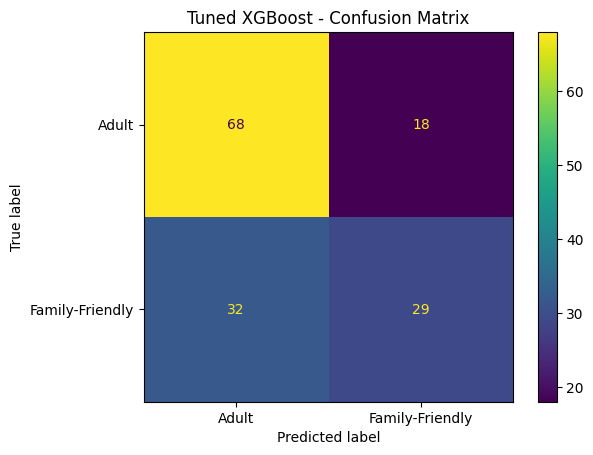

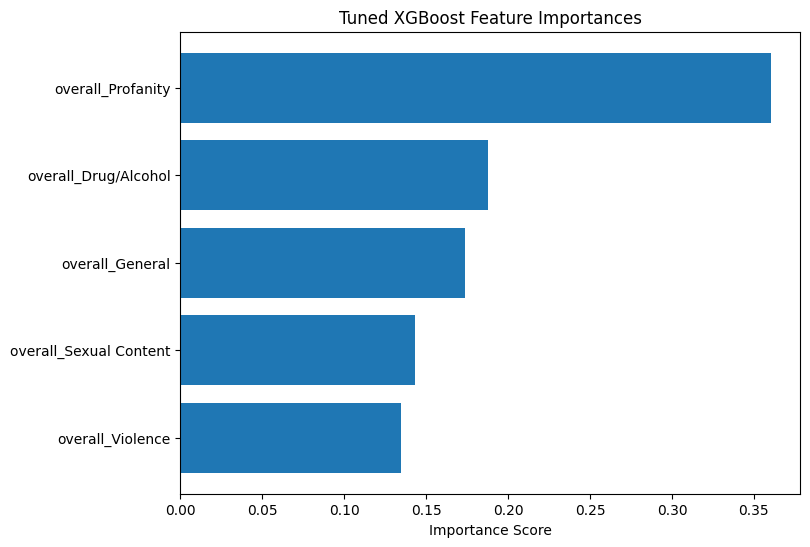


Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  \
Accuracy                    0.673                0.667   
Precision                   0.672                0.662   
Recall                      0.673                0.667   

           Baseline Random Forest  Tuned Random Forest  \
Accuracy                    0.694                0.667   
Precision                   0.690                0.661   
Recall                      0.694                0.667   

           Baseline Gradient Boosting  Tuned Gradient Boosting  DNN Model  \
Accuracy                        0.680                    0.694      0.707   
Precision                       0.677                    0.693      0.708   
Recall                          0.680                    0.694      0.707   

           Tuned DNN Model  Baseline CatBoost  Tuned CatBoost  \
Accuracy             0.735              0.687           0.694   
Precision            0.747              0.689           0.698   
Recall     

In [62]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Encode target labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encode y_train
y_test_encoded = label_encoder.transform(y_test)  # Encode y_test using the same encoder

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [3, 6, 10],          # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'subsample': [0.8, 1.0],          # Fraction of samples for each tree
    'colsample_bytree': [0.8, 1.0]    # Fraction of features for each tree
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1
)

# Perform the grid search
grid_search.fit(X_train, y_train_encoded)

# Get the best parameters and best model
best_params = grid_search.best_params_
print("\nBest Parameters:", best_params)

best_xgb_model = grid_search.best_estimator_

# Predictions on the test set
y_xgb_pred = best_xgb_model.predict(X_test)

# Decode predictions and actual test labels back to original string labels
y_xgb_pred_labels = label_encoder.inverse_transform(y_xgb_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Evaluate the Tuned XGBoost Model
xgb_acc = accuracy_score(y_test_labels, y_xgb_pred_labels)
xgb_precision = precision_score(y_test_labels, y_xgb_pred_labels, average='weighted')
xgb_recall = recall_score(y_test_labels, y_xgb_pred_labels, average='weighted')

print("\nTuned XGBoost Results (Test Set):")
print(f"Accuracy: {xgb_acc:.3f}, Precision: {xgb_precision:.3f}, Recall: {xgb_recall:.3f}\n")

comparison["Tuned XGBoost"] = [xgb_acc, xgb_precision, xgb_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_labels, y_xgb_pred_labels,
    display_labels=label_encoder.classes_  # Display original string labels
)
plt.title("Tuned XGBoost - Confusion Matrix")
plt.show()

print("\n")

# 2. Feature Importance
plt.figure(figsize=(8, 6))
plt.barh(X.columns, best_xgb_model.feature_importances_)
plt.title("Tuned XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.show()

# Display comparison table
print("\nComparison Table:")
print(comparison.round(3))


## Stacking

### Baseline Model


Baseline Stacking Classifier Results (Test Set):
Accuracy: 0.680, Precision: 0.676, Recall: 0.680



<Figure size 800x600 with 0 Axes>

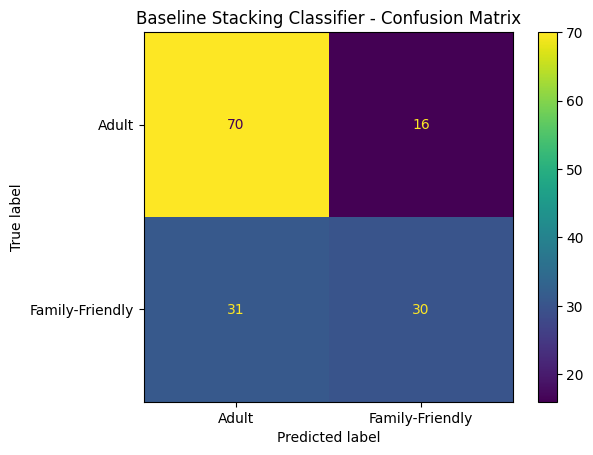




Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  \
Accuracy                    0.673                0.667   
Precision                   0.672                0.662   
Recall                      0.673                0.667   

           Baseline Random Forest  Tuned Random Forest  \
Accuracy                    0.694                0.667   
Precision                   0.690                0.661   
Recall                      0.694                0.667   

           Baseline Gradient Boosting  Tuned Gradient Boosting  DNN Model  \
Accuracy                        0.680                    0.694      0.707   
Precision                       0.677                    0.693      0.708   
Recall                          0.680                    0.694      0.707   

           Tuned DNN Model  Baseline CatBoost  Tuned CatBoost  \
Accuracy             0.735              0.687           0.694   
Precision            0.747              0.689           0.698   
Recall   

In [63]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Encode target labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encode y_train
y_test_encoded = label_encoder.transform(y_test)  # Encode y_test using the same encoder

# Base Models (Simpler Models for Baseline)
base_estimators = [
    ('dt', DecisionTreeClassifier(random_state=42)),  # Decision Tree
    ('rf', RandomForestClassifier(random_state=42))   # Random Forest
]

# Meta-Model (Logistic Regression)
stacking_meta_model = LogisticRegression(random_state=42)

# Stacking Classifier (Baseline)
baseline_stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=stacking_meta_model,
    cv=3  # Cross-validation folds
)

# Train the Baseline Stacking Classifier
baseline_stacking_model.fit(X_train, y_train_encoded)

# Predictions on the test set
y_stack_pred = baseline_stacking_model.predict(X_test)

# Decode predictions and actual test labels back to original string labels
y_stack_pred_labels = label_encoder.inverse_transform(y_stack_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Evaluate the Baseline Stacking Classifier
stack_acc = accuracy_score(y_test_labels, y_stack_pred_labels)
stack_precision = precision_score(y_test_labels, y_stack_pred_labels, average='weighted')
stack_recall = recall_score(y_test_labels, y_stack_pred_labels, average='weighted')

print("\nBaseline Stacking Classifier Results (Test Set):")
print(f"Accuracy: {stack_acc:.3f}, Precision: {stack_precision:.3f}, Recall: {stack_recall:.3f}\n")

comparison["Baseline Stacking"] = [stack_acc, stack_precision, stack_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_labels, y_stack_pred_labels,
    display_labels=label_encoder.classes_  # Display original string labels
)
plt.title("Baseline Stacking Classifier - Confusion Matrix")
plt.show()

print("\n")

# Display comparison table
print("\nComparison Table:")
print(comparison.round(3))


### Tuned Model

Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best Parameters: {'final_estimator__C': 1, 'gb__learning_rate': 0.05, 'gb__n_estimators': 200, 'rf__max_depth': 10, 'rf__n_estimators': 200}

Tuned Stacking Classifier Results (Test Set):
Accuracy: 0.701, Precision: 0.698, Recall: 0.701



<Figure size 800x600 with 0 Axes>

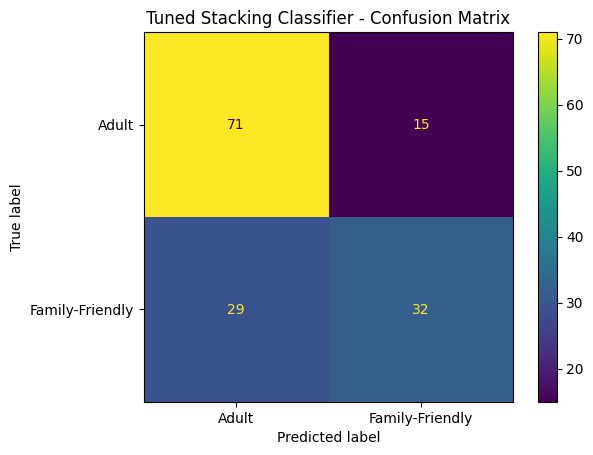




Comparison Table:
           Baseline Decision Tree  Tuned Decision Tree  \
Accuracy                    0.673                0.667   
Precision                   0.672                0.662   
Recall                      0.673                0.667   

           Baseline Random Forest  Tuned Random Forest  \
Accuracy                    0.694                0.667   
Precision                   0.690                0.661   
Recall                      0.694                0.667   

           Baseline Gradient Boosting  Tuned Gradient Boosting  DNN Model  \
Accuracy                        0.680                    0.694      0.707   
Precision                       0.677                    0.693      0.708   
Recall                          0.680                    0.694      0.707   

           Tuned DNN Model  Baseline CatBoost  Tuned CatBoost  \
Accuracy             0.735              0.687           0.694   
Precision            0.747              0.689           0.698   
Recall   

In [65]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Encode target labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encode y_train
y_test_encoded = label_encoder.transform(y_test)  # Encode y_test using the same encoder

# Define base models
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]

# Define the meta-model
meta_model = LogisticRegression(random_state=42, max_iter=1000)

# Initialize Stacking Classifier
stacking_model = StackingClassifier(estimators=base_estimators, final_estimator=meta_model, cv=3)

# Define the parameter grid for tuning the base and meta-models
param_grid = {
    'rf__n_estimators': [100, 200],            # Random Forest: Number of trees
    'rf__max_depth': [5, 10],                 # Random Forest: Depth of the trees
    'gb__n_estimators': [100, 200],           # Gradient Boosting: Number of trees
    'gb__learning_rate': [0.05, 0.1],         # Gradient Boosting: Learning rate
    'final_estimator__C': [0.1, 1, 10]        # Logistic Regression: Regularization strength
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=stacking_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1
)

# Perform the grid search
grid_search.fit(X_train, y_train_encoded)

# Get the best parameters and best model
best_params = grid_search.best_params_
print("\nBest Parameters:", best_params)

best_stacking_model = grid_search.best_estimator_

# Predictions on the test set
y_stack_pred = best_stacking_model.predict(X_test)

# Decode predictions and actual test labels back to original string labels
y_stack_pred_labels = label_encoder.inverse_transform(y_stack_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Evaluate the Tuned Stacking Classifier
stack_acc = accuracy_score(y_test_labels, y_stack_pred_labels)
stack_precision = precision_score(y_test_labels, y_stack_pred_labels, average='weighted')
stack_recall = recall_score(y_test_labels, y_stack_pred_labels, average='weighted')

print("\nTuned Stacking Classifier Results (Test Set):")
print(f"Accuracy: {stack_acc:.3f}, Precision: {stack_precision:.3f}, Recall: {stack_recall:.3f}\n")

comparison["Tuned Stacking"] = [stack_acc, stack_precision, stack_recall]

# Visualizations
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_labels, y_stack_pred_labels,
    display_labels=label_encoder.classes_  # Display original string labels
)
plt.title("Tuned Stacking Classifier - Confusion Matrix")
plt.show()

print("\n")

# Display comparison table
print("\nComparison Table:")
print(comparison.round(3))


## Comparison

In [72]:
print("For\n   Family-Friendly: 'G', 'PG', 'PG-13'\n   Adult: 'R', 'NC-17','NR'")

comparison.round(3)

For
   Family-Friendly: 'G', 'PG', 'PG-13'
   Adult: 'R', 'NC-17','NR'


,Baseline Decision Tree,Tuned Decision Tree,Baseline Random Forest,Tuned Random Forest,Baseline Gradient Boosting,Tuned Gradient Boosting,DNN Model,Tuned DNN Model,Baseline CatBoost,Tuned CatBoost,Baseline XGBoost,Tuned XGBoost,Baseline Stacking,Tuned Stacking
Accuracy,0.673,0.667,0.694,0.687,0.680,0.694,0.707,0.735,0.687,0.694,0.680,0.660,0.680,0.701
Precision,0.672,0.662,0.690,0.686,0.677,0.693,0.708,0.747,0.689,0.698,0.676,0.654,0.676,0.698
Recall,0.673,0.667,0.694,0.687,0.680,0.694,0.707,0.735,0.687,0.694,0.680,0.660,0.680,0.701
